In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

from ler.gw_source_population import CBCSourceRedshiftDistribution
from ler.utils import  interpolator_from_pickle, njit_cubic_spline_interpolator

In [5]:
cbc = CBCSourceRedshiftDistribution(
    z_min=0.001,
    z_max=10.0,
    nsamples_z=500,
    event_type="BBH",
    merger_rate_density="merger_rate_density_bbh_popI_II_oguri2018",
    merger_rate_density_param=dict(R0=23.9 * 1e-9, b2=1.6, b3=2.0, b4=30),
    cosmology=None,
    directory="./interpolator_pickle",
    create_new_interpolator=dict(redshift_distribution=True, z_to_Dl=True, differential_comoving_volume=True)
)
# cbc = CBCSourceRedshiftDistribution(
#     z_min=0.001,
#     z_max=30.0,
#     nsamples_z=500,
#     event_type="BBH",
#     merger_rate_density="merger_rate_density_primordial_ken2022",
#     #merger_rate_density_param=dict(n0=19.2 * 1e-9, aIII=0.66, bIII=0.3, zIII=14.6),
#     cosmology=None,
#     directory="./interpolator_pickle",
#     create_new_interpolator=dict(redshift_distribution=False, z_to_Dl=False, differential_comoving_volume=False)
# )

z_to_Dl interpolator will be generated at ./interpolator_pickle/z_to_Dl/z_to_Dl_2.pickle
differential_comoving_volume interpolator will be generated at ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_0.pickle


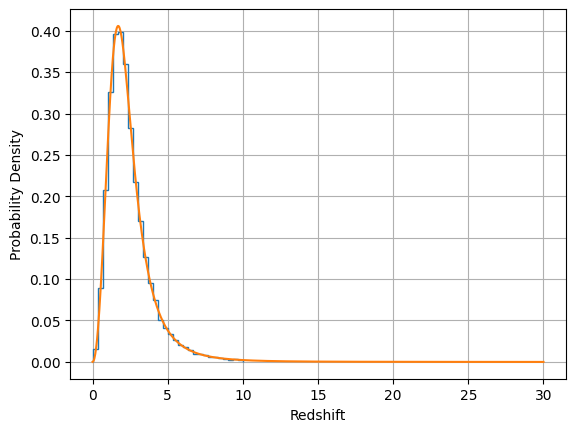

In [16]:
# plot the redshift distribution
z = np.linspace(0.001, 30, 1000)
zs = cbc.sample_source_redshift(50000)
plt.hist(zs, bins=30, density=True, histtype="step")
plt.plot(z, cbc.pdf_z(z, param=None))
#dist = np.random.normal(2,1, 1000)
# plt.hist(dist, bins=30, density=True, histtype="step")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.grid()
plt.show()

## Test for custom njit cubicspline

In [2]:
z = np.linspace(0.001, 10., 500)
spline1 = interpolator_from_pickle(
    param_dict_given= dict(z_min=0.001, z_max=10., cosmology=cosmo),
    directory="./interpolator_pickle",
    sub_directory="z_to_Dl",
    name="z_to_Dl",
    x = z,
    pdf_func= lambda z_: cosmo.luminosity_distance(z_).value, 
    conditioned_y=None, 
    dimension=1,
    category="function",
    create_new=True,
)

z_to_Dl interpolator will be generated at ./interpolator_pickle/z_to_Dl/z_to_Dl_2.pickle


In [3]:
spline1[0]

array([[-1.16659378e+03, -1.16659378e+03, -1.15839852e+03, ...,
        -2.49678737e+00, -2.48214949e+00, -2.48214950e+00],
       [ 3.31541090e+03,  3.24528201e+03,  3.17515313e+03, ...,
         5.42634538e+01,  5.41133614e+01,  5.39641489e+01],
       [ 4.28938629e+03,  4.42084995e+03,  4.54950312e+03, ...,
         1.17892648e+04,  1.17914364e+04,  1.17936021e+04],
       [ 4.28606736e+00,  9.15589490e+01,  1.81437951e+02, ...,
         1.03133848e+05,  1.03370104e+05,  1.03606403e+05]])

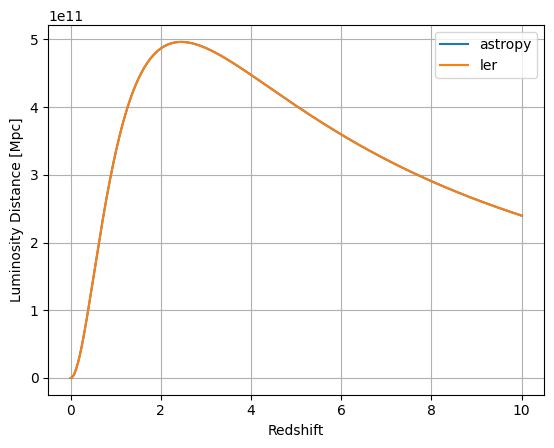

In [8]:
z = np.linspace(0.001, 10, 1000)
plt.plot(z, cbc.cosmo.differential_comoving_volume(z).value* 4 * np.pi , label="astropy")
plt.plot(z, cbc.differential_comoving_volume(z), label="ler")
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.legend()
plt.grid()
plt.show()


## building own interpolator

In [49]:

import numpy as np
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

# Example data points
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([1, 2, 1, 3, 1, 0])

In [19]:
# Create a cubic spline interpolation
%timeit cs = CubicSpline(x, y)

53.8 µs ± 633 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [22]:
%timeit cs2 = interp1d(x, y, kind='cubic')

42.7 µs ± 342 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [100]:
cs2 = interp1d(x, y, kind='cubic', fill_value="extrapolate")
cs2(3.1)

array(3.0115)

In [51]:
# Coefficients of the cubic spline
cs = CubicSpline(x, y)
coefficients = cs.c

In [42]:
xnew = 2.5
i = np.searchsorted(x, xnew) - 1
dx = xnew - x[i]
a, b, c, d = coefficients[:, i]
d + c*dx + b*dx**2 + a*dx**3

2.0625

In [39]:
coefficients

array([[ 1.5,  1.5, -2.5,  1.5,  1.5],
       [-5.5, -1. ,  3.5, -4. ,  0.5],
       [ 5. , -1.5,  1. ,  0.5, -3. ],
       [ 1. ,  2. ,  1. ,  3. ,  1. ]])

In [92]:
np.shape(x)[0]

6

In [109]:
from numba import njit

@njit
def njit_cubic_spline_interpolator(xnew, coefficients, x):
    # Find the right interval for xnew
    i = np.searchsorted(x, xnew) - 1

    # Calculate the relative position within the interval
    dx = xnew - x[i]

    # Calculate the interpolated value
    # Cubic polynomial: a + b*dx + c*dx^2 + d*dx^3
    a, b, c, d = coefficients[:, i]
    #result = a + b*dx + c*dx**2 + d*dx**3
    result = d + c*dx + b*dx**2 + a*dx**3
    return result

@njit
def njit_cubic_spline_interpolator2(xnew, coefficients, x):
    # Handling extrapolation
    i = np.searchsorted(x, xnew) - 1
    idx1 = xnew <= x[0]
    idx2 = xnew > x[-1]
    i[idx1] = 0
    i[idx2] = len(x) - 2

    # Calculate the relative position within the interval
    dx = xnew - x[i]

    # Calculate the interpolated value
    # Cubic polynomial: a + b*dx + c*dx^2 + d*dx^3
    a, b, c, d = coefficients[:, i]
    #result = a + b*dx + c*dx**2 + d*dx**3
    result = d + c*dx + b*dx**2 + a*dx**3
    return result

In [110]:
xnew = np.linspace(-0.2,5.2,100)
value = njit_cubic_spline_interpolator2(xnew, coefficients, x)

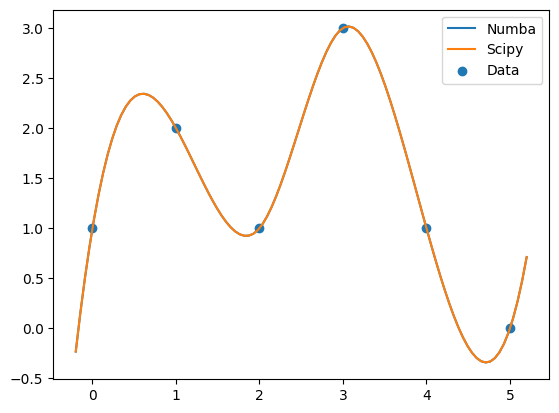

In [111]:
plt.plot(xnew, value, label="Numba")
plt.plot(xnew, cs2(xnew), label="Scipy")
plt.scatter(x, y, label="Data")
plt.legend()
plt.show()

In [105]:
xnew = np.linspace(-0.2,5.2,25000)
%timeit cs2(xnew)

501 µs ± 2.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [108]:
xnew = np.linspace(-0.2,5.2,25000)
%timeit njit_cubic_spline_interpolator2(xnew, coefficients, x)

439 µs ± 2.07 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
